<a href="https://colab.research.google.com/github/ShreyaskarSingh/Computer-Vision/blob/main/Canny_Edge_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import cv2
import math
import random
import copy
import scipy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sympy import *
%matplotlib inline

# **Step 1**
 Creating a one-dimensionl gaussian mask

In [65]:
#function to calculate the Gaussian function
def Gaussian_Mask(x, sigma):
	if sigma == 0:
		return 0
	else:
		g = (np.exp((-(x**2))/float((2*sigma**2))) / float((math.sqrt(2*pi)*sigma)))
		return g 									                                                    


# **Step 2**
Creating a function for calculating the first derivative of Gaussian Mask

In [66]:
# Function to calculate the first derivative of Gauss function 
def DerivativeGaussian(x,sigma):
    G = (((-(x))*(np.exp((-(x*x))/float((2*sigma*sigma))))) / ((sigma*sigma)*(math.sqrt(2*pi)))) 
    return G



# **Step 3**
Defining a Convolving function to one dimensional Gaussian mask with Image

In [67]:
def Convolve(I, G):

  #Creating an temproary array Temp_y  for transposing purpose
  Temp_y = [] 	
  Size = np.shape(I)	
  #Creating an empty array Ix for convolution in x-direction with gaussian mask
  Ix = []	

  #Creating an empty array Iy for convolution in y-direction with gaussian mask
  Iy = []			

  #convolving in the x direction
  for i in range(Size[0]):
    I1 = (np.convolve(I[i,:], G, 'same'))
    Ix.append(np.array(I1))

  #convolving in the y direction
  for i in range(Size[1]):
    I2 = (np.convolve(I[:,i], G, 'same'))
    Temp_y.append(np.array(I2))
    Iy = np.transpose(Temp_y)

  return (Ix,Iy)


# **Step 4**
Creating a derivative convulation function to convolve Ix with Gx and similarly Iy with Gy

In [68]:

def Gaussian_derivative_conv(Ix,Iy,Gx,Gy):

  #Creating an temproary array Temp_y  for transposing purpose
  Temp_y = []
  Shape_x = np.shape(Ix)
  Shape_y = np.shape(Iy)
  Ix2 = []
  Iy2 = []

  #Calculating Ix2
  for i in range(0, Shape_x[0]):
    I1 = (np.convolve(np.array(Ix)[i,:], Gx, 'same'))
    Ix2.append(np.array(I1))

  #Calculating Iy2
  for i in range(0, Shape_y[1]):
    I2 = (np.convolve(np.array(Iy)[:,i], Gy, 'same'))
    Temp_y.append(np.array(I2))
    Iy2 = np.transpose(Temp_y)

  return(Ix2, Iy2)

# **Step 5**
Function to return the magnitude and orientation matrix

In [69]:
def magnitude_orientation(Ix2, Iy2, S):
	
	Mag = np.ones((S[0], S[1]), np.float32)			
	The = np.ones((S[0], S[1]), np.float32)
	for i in range(0, S[0]):
		for j in range(0, S[1]):
			Mag[i][j] = math.sqrt((((Ix2[i][j]**2) + ((Iy2[i][j])**2))))
			The[i][j] = math.degrees(math.atan2(Iy2[i][j], Ix2[i][j]))+180
	return (Mag, The)

# **Step 6**
Defining non-maximum suppression to remove the non local maxima in the magnitude matrix 

In [70]:
def non_maximum_suppression(O, M):

	Copy_M = np.copy(M)
	Shape_m = np.shape(M)
	for i in range(0, Shape_m[0]):
		for j in range(0, Shape_m[1]):
			if ((i>0 and i<(Shape_m[0]-1)) and (j>0 and j<(Shape_m[1]-1))):
				if((0<O[i][j]<22.5) or (157.5<O[i][j]<202.5) or (337.5<O[i][j]<360)):		
					if(M[i][j]<M[i+1][j] or M[i][j]<M[i-1][j]):
						Copy_M[i][j] = 0
				if((22.5<O[i][j]<67.5) or (202.5<O[i][j]<247.5)):						          	
					if (M[i][j]<M[i+1][j-1] or M[i][j]<M[i-1][j+1]):
						Copy_M[i][j] = 0
				if((67.5<O[i][j]<112.5) or (247.5<O[i][j]<292.5)):						        	
					if (M[i][j]<M[i][j-1] or M[i][j]<M[i][j+1]):
						Copy_M[i][j] = 0
				if((112.5<O[i][j]<157.5) or (292.5<O[i][j]<337.5)):						         	
					if (M[i][j]<M[i][j+1] or M[i][j]<M[i][j-1]): 
						Copy_M[i][j] = 0
            
	return Copy_M

# **Step 7**
Implementing Hysteresis function to get final edges in the image

In [71]:
def Hysteresis_Threshold(M1, L, H):
	Size_m = np.shape(M1)
	
	for i in range(Size_m[0]):
		for j in range(Size_m[1]):
			if (M1[i][j]<=L):
				M1[i][j] = 0
			elif (M1[i][j]>=H):
				M1[i][j] = 255
			elif (M1[i][j]>=L and(M1[i][j]<=H)):
				if ((i>0 and i<(Size_m[0]-1)) and (j>0 and j<(Size_m[1]-1))):
					if ((M1[i-1][j-1]>H) or (M1[i][j-1]>H) or (M1[i+1][j-1]>H) or (M1[i-1][j]>H) or (M1[i+1][j]>H) or (M1[i-1][j+1]>H) or (M1[i][j+1]>H) or (M1[i+1][j+1]>H)):
						M1[i][j] = 255
	return M1

# **Final Canny Function to execute all the above functions**

In [72]:
def Canny(Image, sigma):
  img = cv2.imread(Image,0)      #reads the path of the input image
  I = np.array(img)              # converting and storing the image into matrix named I

  G = []
  Gx,Gy = [], []
  size_kernel = 1
  for i in range(-size_kernel,size_kernel+1):
        a = Gaussian_Mask(i,sigma)  
        G.append(a)

  #to create the Ix and Iy arrays we need the shape of the image component, to convolve in the x and y direction
  S = np.shape(I)

  #Creating an empty array Ix: I[i,:]*G
  Ix = []	

  #Creating an empty array Iy: I[:,i]*G
  Iy = []	

  Ix, Iy = Convolve(I,G)

  plt.imshow(Ix,cmap=cm.gray) 
  plt.title('X component of image convolution with  Gaussian')
  plt.show()

  plt.imshow(Iy,cmap=cm.gray)
  plt.title('Y component of convolution with Gaussian')
  plt.show() 

  for i in range(-size_kernel,size_kernel+1):
        b = DerivativeGaussian(i,sigma)
        Gx.append(b)
  
  for i in range(-size_kernel,size_kernel+1):
        c = DerivativeGaussian(i,sigma)
        Gy.append(c)

  
  
  #Creating an empty array I_x: Ix*Gx
  I_x = []

  #Creating an empty array I_y: Iy*Gy
  I_y = []


  I_x, I_y = Gaussian_derivative_conv(Ix, Iy, Gx, Gy)

  plt.imshow(I_x,cmap=cm.gray) 
  plt.title('X component of image convolved with derivative of Gaussian')
  plt.show()
  
  plt.imshow(I_y,cmap=cm.gray) 
  plt.title('Y component of image convolved with derivative of Gaussian')
  plt.show() 

  #creating the magnitude image M and orientation image Theta
  M = np.ones((S[0], S[1]), np.float32)			
  The = np.ones((S[0], S[1]), np.float32)

  M, The = magnitude_orientation(I_x, I_y, S)
  plt.imshow(M,cmap=cm.gray) 
  plt.title('Magnitude')
  plt.show()


  M1 = non_maximum_suppression(The, M)
  
  L = 60
  H = 70
  M1 = Hysteresis_Threshold(M1, L, H)

  plt.imshow(M1,cmap=cm.gray) 
  plt.title('Canny edge detection after non-max suppression')
  plt.show()

  

For sigma: 1.5


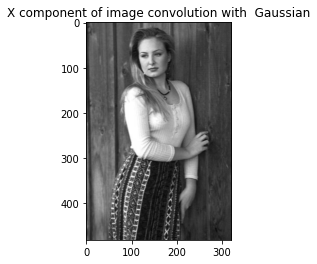

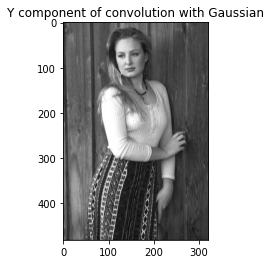

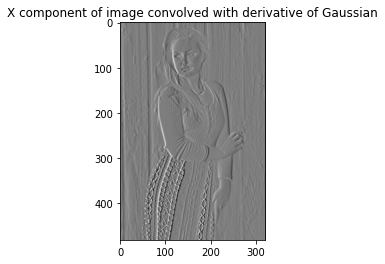

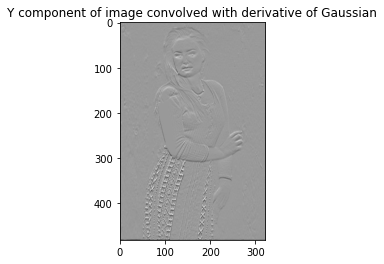

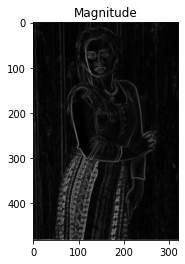

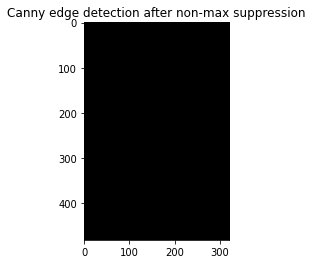

In [73]:
sigma = 1.5
print ("For sigma:", sigma)
Canny('181079.jpg',sigma)

For sigma: 2.5


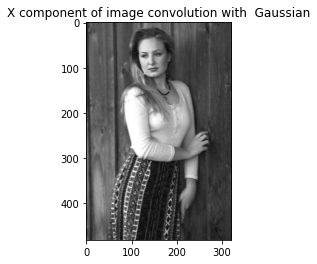

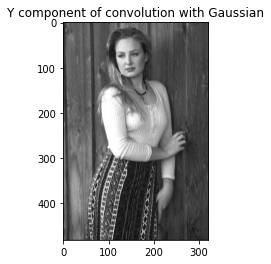

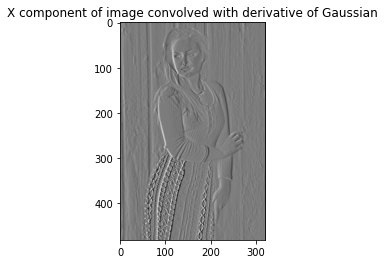

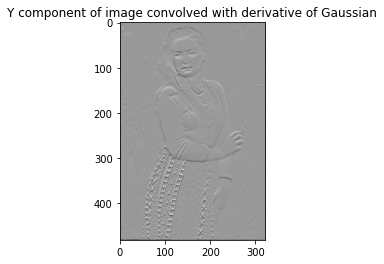

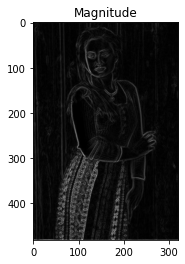

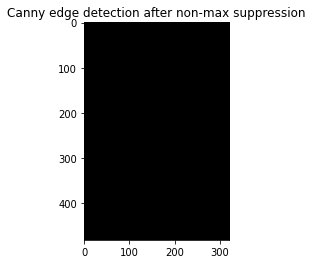

In [74]:
sigma = 2.5
print ("For sigma:", sigma)
Canny('181079.jpg',sigma)

For sigma: 3.5


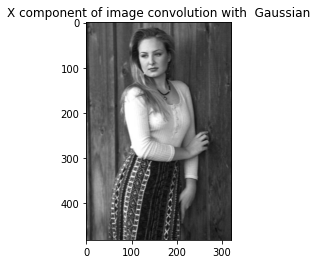

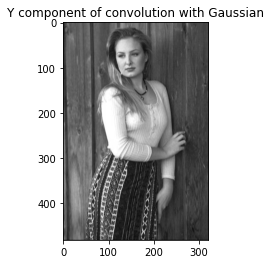

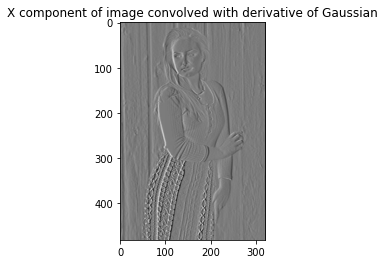

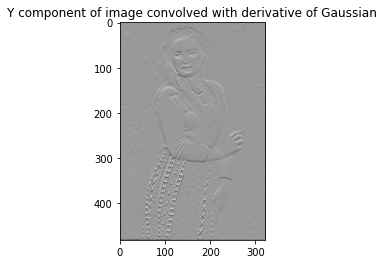

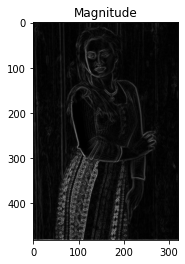

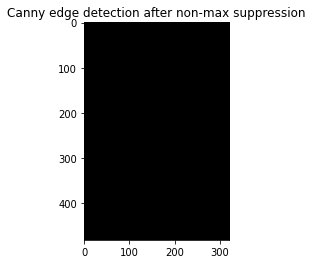

In [75]:
sigma = 3.5
print ("For sigma:", sigma)
Canny('181079.jpg',sigma)